In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from torch.utils import data
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import shutil
import torch
from torch.nn.utils.rnn import pad_sequence
import zipfile
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/DL_workshop/allseqs/type1.pkl /content/
!cp /content/drive/MyDrive/DL_workshop/allseqs/type2.pkl /content/
# !cp /content/drive/MyDrive/DL_workshop/metadata.parquet /content/
# !cp /content/drive/MyDrive/DL_workshop/LE.pkl /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_pkl(file_path):
    with open(file_path + '.pkl', 'rb') as f:
        x = pickle.load(f)
    return x

def save_pkl(obj, file_name):
    with open(file_name + '.pkl', "wb") as f:
        pickle.dump(obj, f)

In [5]:
type1 = load_pkl('type1')
type2 = load_pkl('type2')
# metadata = pd.read_parquet('metadata.parquet')
# LE = load_pkl('LE')



In [6]:
type1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36186 entries, 0 to 50247
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   activity  36186 non-null  int64 
 1   id        36186 non-null  int64 
 2   type      36186 non-null  bool  
 3   full_seq  36186 non-null  object
dtypes: bool(1), int64(2), object(1)
memory usage: 1.1+ MB


In [6]:
assert (type1.shape[0] + type2.shape[0]) == 50248

In [ ]:
def check_seqs_nulls(r):
    if torch.isnan(r['full_seq']).sum().item() >0:
        return True
    return False


n = type2.apply(check_seqs_nulls, axis=1).sum()

f"there are {n} nulls"

'there are 0 nulls'

# Normalize

In [ ]:

global_sum = torch.tensor([0.0, 0.0, 0.0])
global_std = torch.tensor([0.0, 0.0, 0.0])
global_means = torch.tensor([0.0, 0.0, 0.0])


def get_total_lengths(data):
    return data.apply(lambda r: r['full_seq'].shape[0], axis=1).sum()



def means_sequences(data):
    '''
    data: dataframe
    '''
    global global_sum
    # global global_std
    # global total_lengths

    # total_lengths += data.shape[0]
    global_sum += data['full_seq'].sum(axis=0)



def stds_sequences(data):
    '''
    data: dataframe
    '''
    global global_means
    global global_std
    global total_lengths

    # total_lengths += data.shape[0]
    global_std += ((data['full_seq'] - global_means)**2).sum(axis = 0)


# lens = get_total_lengths(type1)
# type1.apply(means_sequences, axis=1)
# global_means = global_sum / lens

# type1.apply(stds_sequences, axis=1)
# global_std = torch.sqrt(global_std / lens)

# type1_norm =  global_means, global_std


global_sum = torch.tensor([0.0, 0.0, 0.0])
global_std = torch.tensor([0.0, 0.0, 0.0])
global_means = torch.tensor([0.0, 0.0, 0.0])

lens = get_total_lengths(type2)
type2.apply(means_sequences, axis=1)
global_means = global_sum / lens

type2.apply(stds_sequences, axis=1)
global_std = torch.sqrt(global_std / lens)

type2_norm =  global_means, global_std


# type1_norm = get_mean_std(type1)
# type2_norm = get_mean_std(type2)


In [ ]:
global_mean = torch.tensor([0.0, 0.0, 0.0])
global_std = torch.tensor([0.0, 0.0, 0.0])

def norma_f(r):

    global global_mean
    global global_std

    global_mean += r.mean(axis=0)
    global_std += r.std(axis = 0)

type1['seq'].apply(func=(norma_f))
type1_norm = (global_std / len(type1)) , (global_mean / len(type1))

global_mean = torch.tensor([0.0, 0.0, 0.0])
global_std = torch.tensor([0.0, 0.0, 0.0])

type2['seq'].apply(func=(norma_f))
type2_norm = (global_std / len(type2)) , (global_mean / len(type2))

In [ ]:
def standardize_seqs(data, m, s):
    '''
    data: dataframe
    m: mean
    s: std
    '''
    eps = 0.0000000000001
    def stand_scaler(r):
        r = (r - m )/ (s+ eps)
        return r

    data.loc['seq'] = data['seq'].apply(stand_scaler)
    return data

type1 =  standardize_seqs(type1, type1_norm[0], type1_norm[1])
type2 =  standardize_seqs(type2, type2_norm[0], type2_norm[1])

<ipython-input-63-91df09819f54>:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  data.loc['seq'] = data['seq'].apply(stand_scaler)
<ipython-input-63-91df09819f54>:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  data.loc['seq'] = data['seq'].apply(stand_scaler)


# combine type1 and type2


In [7]:
processed = pd.concat([type1, type2])
processed.dropna(inplace=True)
del type1
del type2
processed = processed.rename(columns={'full_seq': 'seq'})
processed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50248 entries, 0 to 50246
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   activity  50248 non-null  int64 
 1   id        50248 non-null  int64 
 2   type      50248 non-null  bool  
 3   seq       50248 non-null  object
dtypes: bool(1), int64(2), object(1)
memory usage: 1.6+ MB


In [8]:
class FE_SensorDataset(torch.utils.data.Dataset):
    def __init__(self, metadata,noise_std, t1_norm, t2_norm,augs=None,transform=None):
        self.transform = transform
        self.metadata = metadata
        self.transform = transform
        self.noise_std = noise_std
        self.augs = augs
        self.t1_norm = t1_norm
        self.t2_norm = t2_norm
        # Set a fixed or estimated maximum sequence length
        self.max_seq_length = 4000  # Example default value
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        eps = 0.00000000001

        sample_meta = self.metadata.iloc[idx]

        label = sample_meta['activity']
        sequences = sample_meta['seq']


        # if sample_meta['type']:
        #     sequences = (sequences - self.t1_norm[0])  / (self.t1_norm[1] + eps)
        # else:
        #     sequences = (sequences - self.t2_norm[0])  / (self.t2_norm[1] + eps)

        if self.transform:
            sensor_data = self.transform(sensor_data)

        if sequences.size(0) < self.max_seq_length:
            pad_size = self.max_seq_length - sequences.size(0)
            padding_tensor = torch.zeros(pad_size, sequences.size(1), dtype=torch.float32)
            sequences = torch.cat((sequences, padding_tensor), dim=0)


        # if self.augs:
        #     for aug in self.augs:
        #         sequences = aug(sequences)


        # Add Gaussian noise if specified
        if self.noise_std > 0:
            noise = torch.randn_like(sequences) * self.noise_std
            sequences += noise


        return sequences.float(), label


# Define augmentaition funcs

In [19]:
def jitter(sequence, noise_level=0.05):
    noise = torch.randn_like(sequence) * noise_level
    return sequence + noise

def scaling(sequence, scale_range=(-0.03, 0.1)):
    scale_factor = torch.empty(1).uniform_(scale_range[0], scale_range[1])
    return sequence + scale_factor

def random_crop(sequence, crop_length=3000):
    # print(sequence)
    if sequence.size(0) <= crop_length:
        return sequence
    start = torch.randint(0, sequence.size(0) - crop_length, (1,)).item()
    return sequence[start:start+crop_length]

augmentations = [jitter, scaling, random_crop]

# MODEL

In [20]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)


        self.fc_a = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 1024),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Dropout(0.5),
        )


        self.fc_b = nn.Linear(512, num_classes)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * (2 if self.lstm.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.lstm.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        pre_out = self.fc_a(out[:, -1, :])
        out=self.fc_b(pre_out)
        return out


In [ ]:
class Conv1DNet(nn.Module):
    def __init__(self, in_channels, N_classes, kernel_size, dropout_rate):
        super(Conv1DNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size, stride=1)
        self.pool1 = nn.MaxPool1d(2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size, stride=1)
        self.pool2 = nn.MaxPool1d(2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size, stride=1)
        self.pool3 = nn.MaxPool1d(2, stride=2)

        self.dropout = nn.Dropout(dropout_rate)

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)  

        self._init_fc_layers(N_classes)

    def _init_fc_layers(self, N_classes):
        self.fc1 = nn.Linear(256, 512)  
        self.fc2 = nn.Linear(512, N_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.adaptive_pool(x) 
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        self.fc_a = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 1024),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Dropout(0.5),

        )


        self.fc_b = nn.Linear(512, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * (2 if self.gru.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.gru.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        # out, _ = self.lstm(x, (h0, c0))
        pre_out = self.fc_a(out[:, -1, :])
        out=self.fc_b(pre_out)
        return out

In [13]:
from torch.optim.lr_scheduler import StepLR
def trainmodel(model, train_loader, val_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)  # We can configure an LR scheduler
    scheduler = StepLR(optimizer, step_size=50, gamma=0.99)
    epoch_losses = []
    epoch_accuracies = []
    val_epoch_losses = []
    val_epoch_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set model to training mode
        total_loss = 0
        correct_preds = 0
        total_preds = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device).long()  # Move data to the device
            optimizer.zero_grad()
            outputs = model(sequences)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = correct_preds / total_preds

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(avg_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # In validation phase, we don't need to compute gradients (for memory efficiency)
            val_total_loss = 0
            val_correct_preds = 0
            val_total_preds = 0
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device).long()
                outputs = model(sequences)

                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

            val_avg_loss = val_total_loss / len(val_loader)
            val_avg_accuracy = val_correct_preds / val_total_preds

            val_epoch_losses.append(val_avg_loss)
            val_epoch_accuracies.append(val_avg_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, '
              f'Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_avg_accuracy:.4f}')

    return epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies


In [18]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# model = LSTMNet(input_size=3, hidden_size=100, num_layers=2, num_classes=18)
# model = GRUNet(input_size=3, hidden_size=100, num_layers=2, num_classes=18)
# model = torch.load('model5.pt')

AE_model = torch.load('AE.pt')
AE_model.eval()
for param in AE_model.parameters():
    param.requires_grad = False

model = EmbeddedModel(AE_model)
model.train()
model.to(device)

# Split df into 70% train and 30% temporary data (which will be split into validation and test sets)
train_df, temp_df = train_test_split(processed, test_size=0.3, random_state=42)

# Split temp_df into 50% validation and 50% test, which results in 15% of the original data for each
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

num_epochs=10
batch_size = 128

# Create data loaders for each set
type1_norm = 0
type2_norm = 0
std = 0.015
augmentations = []
train_loader = DataLoader(FE_SensorDataset(train_df,std,type1_norm, type2_norm, augmentations), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(FE_SensorDataset(val_df,std,type1_norm, type2_norm,), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(FE_SensorDataset(test_df,std,type1_norm, type2_norm,), batch_size=batch_size, shuffle=False)



# Then, continue with model training as before
epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies = trainmodel(model, train_loader,val_loader, num_epochs=num_epochs)

cuda
Epoch [1/10], Train Loss: 2.7714, Train Accuracy: 0.0871, Val Loss: 2.7515, Val Accuracy: 0.0872
Epoch [2/10], Train Loss: 2.7471, Train Accuracy: 0.0905, Val Loss: 2.7371, Val Accuracy: 0.0988
Epoch [3/10], Train Loss: 2.7371, Train Accuracy: 0.0944, Val Loss: 2.7321, Val Accuracy: 0.0959
Epoch [4/10], Train Loss: 2.7313, Train Accuracy: 0.0927, Val Loss: 2.7276, Val Accuracy: 0.0927
Epoch [5/10], Train Loss: 2.7284, Train Accuracy: 0.0942, Val Loss: 2.7293, Val Accuracy: 0.0994
Epoch [6/10], Train Loss: 2.7260, Train Accuracy: 0.0971, Val Loss: 2.7238, Val Accuracy: 0.0994
Epoch [7/10], Train Loss: 2.7237, Train Accuracy: 0.0998, Val Loss: 2.7232, Val Accuracy: 0.1011
Epoch [8/10], Train Loss: 2.7226, Train Accuracy: 0.0973, Val Loss: 2.7214, Val Accuracy: 0.0996
Epoch [9/10], Train Loss: 2.7213, Train Accuracy: 0.0989, Val Loss: 2.7195, Val Accuracy: 0.1008
Epoch [10/10], Train Loss: 2.7198, Train Accuracy: 0.0979, Val Loss: 2.7196, Val Accuracy: 0.1018


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# After party

In [ ]:
model

GRUNet(
  (gru): GRU(3, 100, num_layers=2, batch_first=True)
  (fc_a): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Dropout(p=0.5, inplace=False)
  )
  (fc_b): Linear(in_features=512, out_features=18, bias=True)
)

In [21]:
epochs =  [i for i in range(num_epochs)]

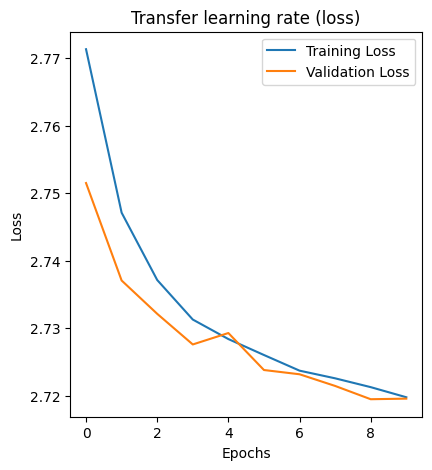

In [23]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_epoch_losses, label='Validation Loss')
plt.title('Transfer learning rate (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

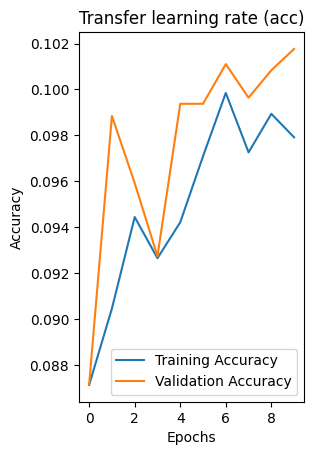

In [24]:
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, epoch_accuracies, label='Training Accuracy')
plt.plot(epochs, val_epoch_accuracies, label='Validation Accuracy')
plt.title('Transfer learning rate (acc)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [25]:
def test_model(model):
    global test_loader
    global batch_size
    all_preds = []
    all_true = []
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # In validation phase, we don't need to compute gradients (for memory efficiency)
        val_total_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device).long()
            outputs = model(sequences)

            loss = criterion(outputs, labels)
            val_total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_accuracy = val_correct_preds / val_total_preds

        print(f'Test Loss: {val_avg_loss:.4f}, Test Accuracy: {val_avg_accuracy:.4f}')
        return all_preds, all_true

all_preds, all_true = test_model(model)

Test Loss: 2.7193, Test Accuracy: 0.1027


In [28]:
from sklearn.metrics import classification_report

x = classification_report(all_true, all_preds)
print(x)

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       219
           1       0.69      0.81      0.75       398
           2       0.60      0.85      0.71       361
           3       0.85      0.71      0.77       336
           4       0.98      0.98      0.98       162
           5       0.98      0.99      0.98       203
           6       0.70      0.81      0.75       165
           7       0.75      0.76      0.75       671
           8       0.76      0.69      0.72       370
           9       0.70      0.71      0.70       710
          10       0.82      0.83      0.83       688
          11       0.69      0.76      0.72       668
          12       0.74      0.88      0.80       604
          13       0.89      0.62      0.73       671
          14       0.86      0.72      0.78       388
          15       0.82      0.76      0.79       374
          16       0.83      0.76      0.79       354
          17       0.81    

In [29]:
true_classifications = []
wrong_classifications = []

# Evaluate the model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Collect true and wrong classifications
        matches = (predicted == labels)
        for i, match in enumerate(matches):
            if match:
                true_classifications.append((inputs[i], predicted[i], labels[i]))
            else:
                wrong_classifications.append((inputs[i], predicted[i], labels[i]))

In [30]:
def plot_sequence_classification(sequence, predicted_label, true_label, label_mapping, title=""):
    """
    This function plots a multi-dimensional sequence where each dimension is annotated with X, Y, Z in the legend,
    and shows its predicted and true classification labels using a label mapping dictionary.
    :param sequence: A multi-dimensional sequence of data points where each column represents a dimension.
    :param predicted_label: The predicted classification label for the sequence, expected to be an integer or tensor.
    :param true_label: The true classification label for the sequence, expected to be an integer or tensor.
    :param label_mapping: A dictionary mapping encoded labels to original labels.
    :param title: A title for the plot.
    """
    sequence = sequence.cpu()
    predicted_label = predicted_label.cpu()
    true_label = true_label.cpu()

    label_mapping = {value: key for key, value in label_mapping.items()}
    predicted_label = predicted_label.item() if isinstance(predicted_label, torch.Tensor) else predicted_label
    true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label

    predicted_label_name = label_mapping[predicted_label]
    true_label_name = label_mapping[true_label]

    plt.figure(figsize=(10, 4))


    labels = ['X', 'Y', 'Z']
    for i in range(min(len(sequence[0]), len(labels))):
        plt.plot(sequence[:, i], label=f'{labels[i]}')

    plt.title(f"{title}\nPredicted Label: {predicted_label_name} \n True Label: {true_label_name}")
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    max_val = np.max(sequence)
    plt.text(len(sequence) // 2, max_val, f'Predicted: {predicted_label_name}', fontsize=12, ha='center', color='blue')
    plt.text(len(sequence) // 2, max_val * 0.95, f'True: {true_label_name}', fontsize=12, ha='center', color='red')

    plt.show()

with open('/content/LE.pkl', 'rb') as f:
    label_mapping = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/LE.pkl'

In [ ]:
plot_sequence_classification(true_classifications[5][0],true_classifications[5][1],true_classifications[5][2],label_mapping)

# Produce submission file

## Load required data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/bgu-i-know-what-you-did-last-measurement-time.zip'

# Path to extract the contents in Colab storage
extract_path = '/content/files/'

# Import necessary libraries
import zipfile
import os

# Create a directory to extract the files if not exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files: ['unlabeled', 'train.csv']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !cp /content/drive/MyDrive/DL_workshop/allseqs/type1.pkl /content/
# !cp /content/drive/MyDrive/DL_workshop/allseqs/type2.pkl /content/
!cp /content/drive/MyDrive/DL_workshop/metadata.parquet /content/
!cp /content/drive/MyDrive/DL_workshop/LE.pkl /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# metadata = pd.read_parquet('metadata.parquet')
LE = load_pkl('LE')

## Data class

In [ ]:
# @title Default title text
class Sub_SensorDataset(torch.utils.data.Dataset):
    def __init__(self, test_ids,t1_norm, t2_norm,transform=None):
        self.transform = transform
        # self.seq_data_dir = seq_data_dir
        # self.metadata = metadata
        # self.transform = transform
        # self.noise_std = noise_std
        self.t1_norm = t1_norm
        self.t2_norm = t2_norm
        self.test_ids = test_ids
        # Set a fixed or estimated maximum sequence length
        self.max_seq_length = 4000  # Example default value
    def __len__(self):
        return 74744

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # sample_meta = self.metadata.iloc[idx]
        file_name = self.test_ids[idx]
        sequences = pd.read_csv(f'/content/files/unlabeled/unlabeled/{file_name}.csv')
        type = False
        # sequences = pd.read_csv(f'/content/{file_name}.csv')
        sequences.fillna(method='bfill', inplace=True)
        if len(sequences.columns) == 4:
            type = True
            sequences = sequences[sequences['measurement type'] == 'acceleration [m/s/s]'].iloc[: , 1:]

        sequences = sequences.values.astype(float)
        sequences = torch.tensor(sequences)



        # if type:
        #     sequences = (sequences - self.t1_norm[0])  / (self.t1_norm[1] + eps)
        # else:
        #     sequences = (sequences - self.t2_norm[0])  / (self.t2_norm[1] + eps)


        if self.transform:
            sequences = self.transform(sequences)

        if sequences.size(0) < self.max_seq_length:
            pad_size = self.max_seq_length - sequences.size(0)
            padding_tensor = torch.zeros(pad_size, sequences.size(1), dtype=torch.float32)
            sequences = torch.cat((sequences, padding_tensor), dim=0)


        return sequences.float(), idx

# Prepare the data

In [ ]:
# get submission ids
ids = pd.read_csv('sample_submission.csv')
test_ids = ids['sample_id'].values


model = torch.load('model5.pt')
# model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 128
sub_test_loader = DataLoader(Sub_SensorDataset(test_ids, 0, 0), batch_size=batch_size, shuffle=False)

# define test func

In [ ]:
def test_model(model, sub_df):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # In validation phase, we don't need to compute gradients (for memory efficiency)
        for sequences, idxs in sub_test_loader:
            sequences = sequences.to(device)

            probs = model(sequences)

            # do softmax on probs
            probs = torch.softmax(probs, dim=1)
            # probs, _ = torch.max(outputs, 1)
            # print(probs, probs.shape)
            # return probs.cpu().numpy()
            # break
            # print(sub_df.loc[idxs, :].shape)
            sub_df.loc[idxs, 1:] =  probs.cpu().numpy()  # Update the DataFrame with the predictions
            # print(probs.shape)
            # print(sub_df.iloc[sub_df.isna().any(axis=1)].shape)
            # sub_df.loc[sub_df.isna().any(axis=1), 1:] =  probs.cpu().numpy()

    return sub_df




In [ ]:
from google.colab import files
sub_df = test_model(model, ids)

assert len(sub_df) == len(test_ids)

sub_df.to_csv('submission55.csv', index=False)
from google.colab import files

# files.download('model5.pkl')
# files.download('submission5.csv')

<ipython-input-39-d8361d476cdc>:16: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub_df.loc[idxs, 1:] =  probs.cpu().numpy()  # Update the DataFrame with the predictions
<ipython-input-39-d8361d476cdc>:16: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub_df.loc[idxs, 1:] =  probs.cpu().numpy()  # Update the DataFrame with the predictions
<ipython-input-39-d8361d476cdc>:16: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub_df.loc[idxs, 1:] =  probs.cpu().numpy()  # Update the DataFrame with the predictions
<ipython-input-39-d8361d476cdc>:16: FutureWarning: Slicing a positional slice with .loc is not supported, 

In [ ]:

# sub_df = pd.read_csv('submission.csv')
# subdf = sub_df.iloc[:, 1:]
# sub_df[sub_df.isna().any()]
sub_df.shape

sub_df.to_csv('submission55.csv', index=False)